# Face Recognition using FaceNet
* Author: Johannes Maucher
* Last update: 08.06.2021

Conventional methods for face recognition (before the rise of deep learning), are e.g. the Eigenface approach by [Turk and Pentland: Face Recognition using Eigenfaces](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf) or the [Fisherfaces approach by Belhumeur et al](https://cseweb.ucsd.edu/classes/wi14/cse152-a/fisherface-pami97.pdf). Both of these approaches calculate a low-dimensional subspace from the high dimensonal image space. Once this subspace is determined, by PCA or FLDA, respectively, all images are transformed into this subspace and recognition, e.g. simple nearest-neighbour recognition, is performed there. See [J. Maucher: Lecture Object Recognition](https://gitlab.mi.hdm-stuttgart.de/maucher/or/-/blob/master/Slides/V04SubspaceFeatures.pdf) for details on these approaches.

FaceNet is a CNN-based face recognition system that was introduced in [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832). For a given image of a face, FaceNet calculates a vector of length 128, the so called **face embedding**. That is, similar as the conventional approaches, Eigenface and Fisherface, also FaceNet transforms the high-dimensional image space into a low-dimensional subspace. This low-dimensional embedding can be used as input for any supervised machine learning algorithm, e.g. a Support Vector Machine (SVM).

The overall process, implemented in this notebook, is summarized in this picture:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/faceRecognitionOverall.png" alt="Drawing" style="width: 800px;"/>

## Some fundamentals on FaceNET

FaceNet is a deep Convolutional Neural Network (CNN), which calculates from face-images at it's input so called face-embeddings (vectors of length 128) at it's output. FaceNet is trained such that the face-embedding vectors of images, which contain the same person, are close to each other and the vectors from images of different persons have a large euclidean distance in between. 

### Architecture

The authors of the [FaceNet paper](https://arxiv.org/abs/1503.03832) propose two different CNN architectures that can be applied. The first and less complex one is a CNN as introduced in [Zeiler & Fergus: Visualizing and Understanding CNNs](https://arxiv.org/abs/1311.2901). The second one is an Inception-Net like introduced in [Szegedy et al: Going deeper with convolutions (GoogLeNet)](https://arxiv.org/abs/1409.4842). The pretrained-FaceNet CNN applied in this notebook is even more complex - the Inception-ResNet as introduced in [Szegedy et al: Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/abs/1602.07261). Independent of the concrete CNN, the abstract architecture is as depicted below:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/faceNetGeneralArchitecture.png" alt="Drawing" style="width: 500px;"/>

Source: [FaceNet paper](https://arxiv.org/abs/1503.03832) 

### Triplet loss
The triplet loss is the most important part of the FaceNet approach. The authors put it as follows:

> *The triplet loss ... directly reflects what we want to achieve in face verification, recognition and clustering. Namely, we strive for an embedding $f(x)$, from an image $x$ into a feature space $\cal{R}^d$, such that the squared distance between all faces, independent of imaging conditions, of the same identity is small, whereas the squared distance beetween a pair of face images from different identities is large.*

The goal of the triplet loss is to ensure that an image $x_i^a$ (anchor) of a specific person is closer to all other images $x_i^p$ (positive) of the same person than it is to any image $x_i^n$ (negative) of any other person. This is visualized in the figure below:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/faceNetLoss.png" alt="Drawing" style="width: 400px;"/>

Source: [FaceNet paper](https://arxiv.org/abs/1503.03832) 

More formally, the following relation shall be fulfilled:

$$
|| f(x_i^a) - f(x_i^p) ||_2^2 + \alpha < || f(x_i^a) - f(x_i^n) ||_2^2, \quad \forall (f(x_i^a), f(x_i^p), f(x_i^n) \in \cal{T},
$$

where $\alpha$ is a margin that is enforced between positive and negative pairs. This implies that the following loss function must be minimized:

$$
L=\sum\limits_{i=1}^N \left[ || f(x_i^a) - f(x_i^p) ||_2^2 -  || f(x_i^a) - f(x_i^n) ||_2^2 + \alpha  \right].
$$

If just all possible triplets $\cal{T}$ are applied, training would converge slowly, because many triplets already fulfill the inequality-relation formulated above and won't yield weight-adaptations. Therefore, the authors of the FaceNet paper suggest a specific **triplet selection process** such that for a given anchor $x_i^a$ only those positives are selected, for which $|| f(x_i^a) - f(x_i^p) ||_2^2$ is maximal and only those negatives are selected, for which $|| f(x_i^a) - f(x_i^n) ||_2^2$ is minimal. For details please refer to [FaceNet paper](https://arxiv.org/abs/1503.03832).     

## Apply pretrained FaceNet for calculating face embeddings

In this notebook a pre-trained Keras FaceNet model from this project [https://github.com/nyoki-mtl/keras-facenet](https://github.com/nyoki-mtl/keras-facenet) will be applied. The model itself must be downloaded from [facenet_keras.h5](https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn). It was trained on [MS-Celeb-1M dataset](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/). The pre-trained model expects input images to 
* be color, 
* have their pixel values whitened (standardized across all three channels),
* have a square shape of 160×160 pixels.


In [26]:
from architecture import *

In [27]:
from warnings import filterwarnings
filterwarnings("ignore")

In [28]:
model = InceptionResNetV2()
path = "weights/facenet_keras_weights.h5"
model.load_weights(path)

In [29]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_398')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


The output of the previous code-cell tells that the input to FaceNet must be of shape $(160,160,3)$ and it's output is a vector of length $128$. The entire FaceNet architecture is summarized below. As can be seen FaceNet is a combination of inception-net and resnet.

In [30]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_398 (InputLayer)          [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_398[0][0]                  
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

## Detect faces in the training-, validation- and test-images

For training and test the [5 Celebrities Dataset](https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset#) is applied. Download this dataset from Kaggle. The dataset contains images of 5 celebrities, subdivided into a training-, validation and test-partition. If you inspect the images you will realize, that the images do not only contain the face of the persons. Therefore, we first have to crop the faces from the entire images as described in notebook [faceDetection.ipynb](faceDetection.ipynb). We reimplement the corresponding method `extract_face()` from there.

In [31]:
#!pip install mtcnn
import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [32]:
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from numpy import savez_compressed,load, expand_dims
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

In [33]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


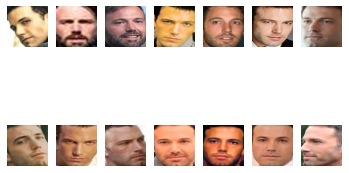

In [9]:
# specify folder to plot
#datafolder='/Users/maucher/gitprojects/or/nb/Data/5celebritiesDataset'
datafolder='/Users/johannes/gitprojects/or/nb/Data/5celebritiesDataset'
folder = datafolder+'/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
    # path
    path = folder + filename
    # get face
    face = extract_face(path)
    print(i, face.shape)
    # plot
    pyplot.subplot(2, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

The function `load_faces(directory)` applies the `extract_face()`-method to all images in `directory` and returns a list of cropped faces.

In [34]:
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

The function `load_dataset(directory)` scans all subdirectories of `directory`. For each subdirectory it invokes the `load_faces()`-function which returns a list of all cropped faces of the person whose images are saved in the subdirectory.  As can be seen below the call of `load_dataset("train")` returns all faces and their corresponding labels used for training and `load_dataset("val")` returns all faces and their corresponding labels used for validation. 

In [37]:
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [38]:
trainX, trainy = load_dataset(datafolder+'/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(datafolder+'/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format

>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
(25, 160, 160, 3) (25,)


In [13]:
savez_compressed('5celebritiesDataset.npz', trainX, trainy, testX, testy)

## Calculate FaceNet-embeddings

In [14]:
data = load('5celebritiesDataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


Within the following function `get_embedding(model,face_pixels)` the pretrained FaceNet model is applied to calculate for the passed face the corresponding face-embedding, which is a vector of length 128. Before passing the face image to the model it must be standardized.

In [40]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]


In [41]:
# load the face dataset
data = load("5celebritiesDataset.npz")
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In the next code-cell each face in the training-set is converted to its face-embedding:

In [17]:
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(93, 128)


Then, also for the face-images in the validation dataset the corresponding face-embeddings are calculated.

In [18]:
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(25, 128)


Finally, the train- and test-embeddings an the corresponding labels are saved persistently:

In [19]:
savez_compressed('5celebritiesEmbeddings.npz', newTrainX, trainy, newTestX, testy)

## Apply FaceNet Embeddings to train a SVM classifier

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
from matplotlib import pyplot

In [43]:
data = load('5celebritiesDataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5celebritiesEmbeddings.npz')

### Preprocessing

In [44]:
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

Dataset: train=93, test=25


### Training

In [45]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

### Validation

In [46]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


Predicted: elton_john (91.049)
Expected: elton_john


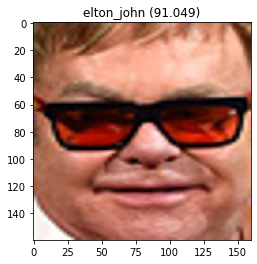

In [47]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()